In [43]:
from copy import copy

%matplotlib inline
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry as sgeom
from osgeo import gdal, ogr
import os
import subprocess as sp
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import numpy.ma as ma
from pandas.tseries import offsets
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io import img_tiles
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import subprocess as sp
from matplotlib.transforms import offset_copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib
%matplotlib inline

In [44]:
def listall(RootFolder, varname='',extension='.png'):
    lists = [os.path.join(root, name)
             for root, dirs, files in os.walk(RootFolder)
             for name in files
             if varname in name
             if name.endswith(extension)]
    return lists

In [100]:
def scale_bar(ax, length, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    """
    #Projection in metres, need to change this to suit your own figure
    utm = img_tiles.GoogleTiles().crs#ccrs.UTM(36)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    #Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * 500, sbcx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbcx, sbcy, str(length) + ' km', transform=utm,
            horizontalalignment='center', verticalalignment='bottom', size=13)

In [46]:
import matplotlib.colors as mcolors
import matplotlib

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)
c = mcolors.ColorConverter().to_rgb

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    
    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in xrange(N+1) ]
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

def setMap(rasterBase):

    # Read the data and metadata
    ds = gdal.Open(rasterBase)
    #band = ds.GetRasterBand(20)
    
    data = ds.ReadAsArray()
    gt = ds.GetGeoTransform()
    #proj = ds.GetProjection()
    
    nan = ds.GetRasterBand(1).GetNoDataValue()
    if nan != None:
        data = np.ma.masked_equal(data,value=nan)
    
    xres = gt[1]
    yres = gt[5]
    
    # get the edge coordinates and add half the resolution 
    # to go to center coordinates
    xmin = gt[0] + xres * 0.5
    xmax = gt[0] + (xres * ds.RasterXSize) - xres * 0.5
    ymin = gt[3] + (yres * ds.RasterYSize) + yres * 0.5
    ymax = gt[3] - yres * 0.5
    
    x = ds.RasterXSize 
    y = ds.RasterYSize  
    extent = [ gt[0],gt[0]+x*gt[1], gt[3],gt[3]+y*gt[5]]
    #ds = None
    img_extent = (extent[0], extent[1], extent[2], extent[3])
    
    # create a grid of xy coordinates in the original projection
    #xy_source = np.mgrid[xmin:xmax+xres:xres, ymax+yres:ymin:yres]
    
    return extent, img_extent#, xy_source, proj

In [34]:
def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])


def lambert_xticks(ax, ticks, label=True):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    if label == True:        
        ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])
    if label == False:
        ax.set_xticklabels([])
    

def lambert_yticks(ax, ticks, label=True):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    if label == True:
        ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])
    if label == False:
        ax.set_yticklabels([])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:    
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

In [154]:
# Create a Lambert Conformal projection:
proj = ccrs.LambertConformal(central_longitude=117.175, central_latitude=33.65,
                             false_easting=400000, false_northing=400000,
                             standard_parallels=(33, 34))

extent = [116.84693268,117.42693268,33.27324112,34.10324112]
xticks = [116.75,117,117.25,117.5]
yticks = [33.1,33.4,33.7,34,34.4]

# prulletaria
ogr2ogr = r'C:\Program Files\GDAL//ogr2ogr.exe'
base_geom = r'D:\Data\ChinaShapefile\CHN_adm'
# county
in_file_county = base_geom + '//CHN_adm3.shp'    
outfile_county = 'county.shp'

command = [ogr2ogr, '-f', "ESRI Shapefile", outfile_county, in_file_county,'-clipsrc',
           str(extent[0]-0.5),str(extent[3]+0.5),str(extent[1]+0.5),str(extent[2]-0.5),
           '-overwrite']
print (sp.list2cmdline(command))
norm = sp.Popen(sp.list2cmdline(command),stdout=sp.PIPE, shell=True)
norm.communicate()
# first color is now gray, orignal brown was  #939393
cb_NDVI = make_colormap([c('#939393'), c('#6E423C'),0.11, c('#6E423C'), c('#87523B'),0.125, 
                         c('#87523B'), c('#A36C34'),0.25, c('#A36C34'), c('#BF9123'),0.375, 
                         c('#BF9123'), c('#DBC712'),0.5,  c('#DBC712'), c('#B3D604'),0.625, 
                         c('#B3D604'), c('#51B004'),0.75, c('#51B004'), c('#0A8701'),0.875, 
                         c('#0A8701'), c('#01611F'),1, c('#01611F')])

"C:\Program Files\GDAL//ogr2ogr.exe" -f "ESRI Shapefile" county.shp D:\Data\ChinaShapefile\CHN_adm//CHN_adm3.shp -clipsrc 116.34693268 34.60324112 117.92693268 32.77324112 -overwrite


In [113]:
# get array informaiton
mcd12q1 = r'D:\Data\NDAI_VHI_GROUNDTRUTH//mcd12q1_h27v05_v3.tif'
extent_mcd12q1, img_extent_mcd12q1 = setMap(mcd12q1)

ds_mcd12q1 = gdal.Open(mcd12q1)
array_mcd12q1 = ds_mcd12q1.ReadAsArray()
array_mcd12q1 = ma.masked_equal(array_mcd12q1,12)
array_mcd12q1 = np.flipud(array_mcd12q1)

In [251]:
ndvi_0405 = r'J:\NDVI_recon_Yongqiao//NDVI_Yongqiao_2005-06-01.tif'
extent_ndvi, img_extent_ndvi = setMap(ndvi_0405)

ds_0405 = gdal.Open(ndvi_0405)
array_0405 = ds_0405.ReadAsArray()
array_0405 = np.flipud(array_0405)
array_0405 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), 
                                 array_0405)

ndvi_0506 = r'J:\NDVI_recon_Yongqiao//NDVI_Yongqiao_2006-06-01.tif'
ds_0506 = gdal.Open(ndvi_0506)
array_0506 = ds_0506.ReadAsArray()
array_0506 = np.flipud(array_0506)
array_0506 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), 
                                 array_0506)

ndvi_0607 = r'J:\NDVI_recon_Yongqiao//NDVI_Yongqiao_2007-06-01.tif'
ds_0607 = gdal.Open(ndvi_0607)
array_0607 = ds_0607.ReadAsArray()
array_0607 = np.flipud(array_0607)
array_0607 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), 
                                 array_0607)

ndvi_0708 = r'J:\NDVI_recon_Yongqiao//NDVI_Yongqiao_2008-06-01.tif'
ds_0708 = gdal.Open(ndvi_0708)
array_0708 = ds_0708.ReadAsArray()
array_0708 = np.flipud(array_0708)
array_0708 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), 
                                 array_0708)

ndvi_0809 = r'J:\NDVI_recon_Yongqiao//NDVI_Yongqiao_2009-06-01.tif'
ds_0809 = gdal.Open(ndvi_0809)
array_0809 = ds_0809.ReadAsArray()
array_0809 = np.flipud(array_0809)
array_0809 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), 
                                 array_0809)

ndvi_0910 = r'J:\NDVI_recon_Yongqiao//NDVI_Yongqiao_2010-06-01.tif'
ds_0910 = gdal.Open(ndvi_0910)
array_0910 = ds_0910.ReadAsArray()
array_0910 = np.flipud(array_0910)
array_0910 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), 
                                 array_0910)

ndvi_1011 = r'J:\NDVI_recon_Yongqiao//NDVI_Yongqiao_2011-06-01.tif'
ds_1011 = gdal.Open(ndvi_1011)
array_1011 = ds_1011.ReadAsArray()
array_1011 = np.flipud(array_1011)
array_1011 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), 
                                 array_1011)

ndvi_1112 = r'J:\NDVI_recon_Yongqiao//NDVI_Yongqiao_2012-06-01.tif'
ds_1112 = gdal.Open(ndvi_1112)
array_1112 = ds_1112.ReadAsArray()
array_1112 = np.flipud(array_1112)
array_1112 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), 
                                 array_1112)

ndvi_1213 = r'J:\NDVI_recon_Yongqiao//NDVI_Yongqiao_2013-06-01.tif'
ds_1213 = gdal.Open(ndvi_1213)
array_1213 = ds_1213.ReadAsArray()
array_1213 = np.flipud(array_1213)
array_1213 = ma.masked_where(np.logical_not(ma.getmask(array_mcd12q1)), 
                                 array_1213)

In [252]:
ndvi_1213[-14:-4]

'2013-06-01'

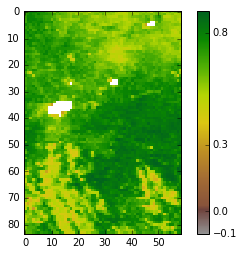

In [196]:
bounds = [-0.1,0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9]
cmap = cmap_discretize(cb_NDVI,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

im = plt.imshow(array_0405/10000., cmap=cb_NDVI, vmin=-0.1, vmax=0.9,
               interpolation='nearest')#, norm=norm)
plt.colorbar(im, ticks=[-0.1,0,0.3,0.8])

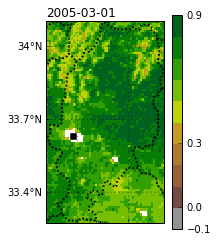

In [197]:
# Draw a set of axes with coastlines:
fig = plt.figure(figsize=(9, 13), frameon=True)

# PLOT 1
ax = plt.subplot(331, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_0405/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
plt.colorbar(im, ticks=[-0.1,0,0.3,0.9], ax=ax)
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title('2005-03-01',loc='left')

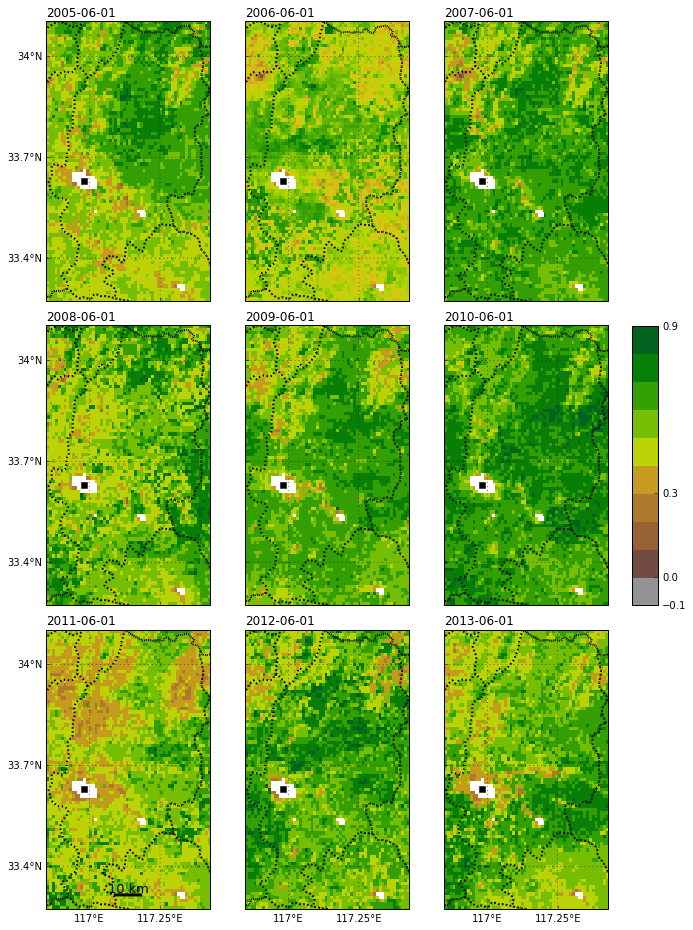

In [253]:
# Draw a set of axes with coastlines:
fig = plt.figure(figsize=(9, 13), frameon=True)

# PLOT 1
ax = plt.subplot(331, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_0405/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_0405[-14:-4],loc='left')

# PLOT 2
ax = plt.subplot(332, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_0506/10000., origin='upper', extent=img_extent_ndvi, 
               cmap=cb_NDVI, vmin=-0.1, vmax=0.9, 
               interpolation='nearest', transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_0506[-14:-4],loc='left')

# PLOT 3
ax = plt.subplot(333, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_0607/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_0607[-14:-4],loc='left')

# PLOT 4
ax = plt.subplot(334, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_0708/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_0708[-14:-4],loc='left')

# PLOT 5
ax = plt.subplot(335, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_0809/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_0809[-14:-4],loc='left')

# PLOT 6
ax = plt.subplot(336, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=False)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_0910/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_0910[-14:-4],loc='left')

# PLOT 7
ax = plt.subplot(337, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_1011/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_1011[-14:-4],loc='left')
scale_bar(ax, 10)

# PLOT 8
ax = plt.subplot(338, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_1112/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_1112[-14:-4],loc='left')

# PLOT 9
ax = plt.subplot(339, projection=proj)
ax.set_extent(extent, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks, label=False)
ax.add_geometries(Reader(outfile_county).geometries(), ccrs.PlateCarree(), 
                  facecolor='',linestyle=':', linewidth=2)#, zorder = 5)
im = ax.imshow(array_1213/10000., origin='upper', extent=img_extent_ndvi, norm=norm, 
               cmap=cmap, vmin=-0.1, vmax=0.9, interpolation='nearest', 
               transform=ccrs.PlateCarree())
ax.plot(116.98, 33.63, marker='s', color='k', markersize=6,
        transform=ccrs.PlateCarree())
ax.set_title(ndvi_1213[-14:-4],loc='left')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.00, 0.35, 0.04, 0.298])
fig.colorbar(im, cax=cbar_ax, ticks=[-0.1,0,0.3,0.9])

plt.tight_layout()
plt.savefig(r'D:\Data\NDAI_VHI_GROUNDTRUTH\png//Yongqiao_'+ndvi_1213[-9:-4]+'.png', 
            dpi=400, bbox_inches='tight')

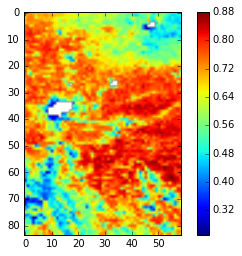

In [192]:
im = plt.imshow(array_1213/10000.)
plt.colorbar(im)